In [1]:
import pandas as pd
import gurobipy as gp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('price_demand_data.csv')
print(data.head())

   price  demand
0   1.05     283
1   0.86     771
2   1.21     185
3   0.94     531
4   0.76    1002


In [3]:
X = data['price'].values.reshape(-1, 1)  
y = data['demand'].values  

model = LinearRegression()
model.fit(X, y)

beta_0 = model.intercept_
beta_1 = model.coef_[0]

print(f"Beta0: {beta_0}, Beta1: {beta_1}")

Beta0: 1924.7175435291083, Beta1: -1367.712524162598


In [4]:
residuals = y - model.predict(X)

print(f"Residuals: {residuals[:10]}")

Residuals: [-205.61939316   22.51522725  -84.78538929 -108.06777082  116.74397483
 -103.87039896 -126.90177468  -76.13052227   -2.80764751  163.83810201]


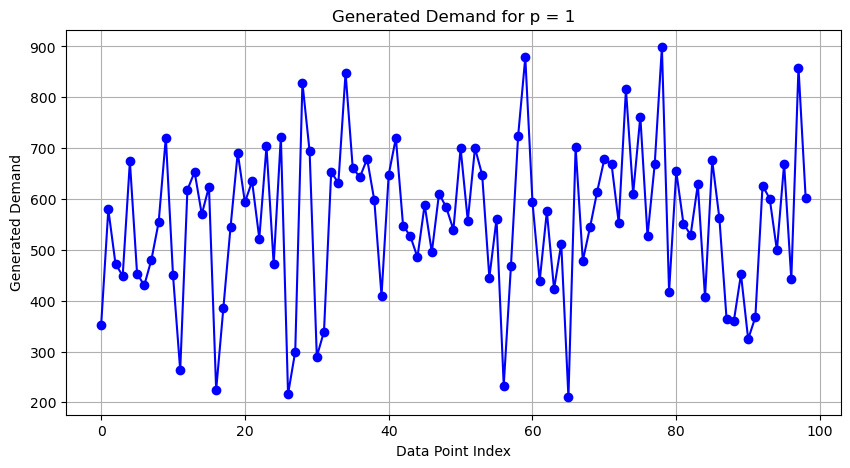

In [5]:
p = 1  # Price is fixed at 1
generated_demand = beta_0 + (beta_1 * p) + residuals  

plt.figure(figsize=(10, 5))
plt.plot(generated_demand, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Data Point Index')
plt.ylabel('Generated Demand')
plt.title('Generated Demand for p = 1')

# Show the plot
plt.grid(True)
plt.show()

In [6]:
c = 0.5
g = 0.75
t = 0.15
p = 1  

m = gp.Model("newspaper_production_deviation1")


q = m.addVar(name="q", lb=0, vtype=gp.GRB.INTEGER) ## quantity integer

# Create a variable for the profit on each day (h_i)
n = len(generated_demand)
h = m.addVars(n, name="h", lb=-gp.GRB.INFINITY)

max_demand_minus_q = m.addVars(n, name="max_demand_minus_q", lb=0, vtype=gp.GRB.CONTINUOUS)
max_q_minus_demand = m.addVars(n, name="max_q_minus_demand", lb=0, vtype=gp.GRB.CONTINUOUS)

# Define the max constraints for each i 
for i in range(n):
    m.addConstr(max_demand_minus_q[i] >= generated_demand[i] - q)  # max(D_i - q, 0)
    m.addConstr(max_q_minus_demand[i] >= q - generated_demand[i])  # max(q - D_i, 0)

# Define the objective function: maximize average profit (sum of h_i's over n days)
m.setObjective(gp.quicksum(h[i] for i in range(n)) / n, gp.GRB.MAXIMIZE)

# Constraints for each day's profit (this should use the max variables created above)
for i in range(n):
    demand_i = generated_demand[i]
    # Profit formula: p * D_i - q * c - g * max(D_i - q, 0) - t * max(q - D_i, 0)
    m.addConstr(h[i] <= p * demand_i - q * c - g * max_demand_minus_q[i] - t * max_q_minus_demand[i])

# Optimize the model
m.optimize()

# Output the results
if m.status == gp.GRB.OPTIMAL:
    optimal_q = q.x
    print(f"Optimal quantity to print: {optimal_q}")
else:
    print("No optimal solution found.")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297 rows, 298 columns and 792 nonzeros
Model fingerprint: 0x3cfb9259
Variable types: 297 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 9e+02]
Presolve removed 296 rows and 198 columns
Presolve time: 0.01s
Presolved: 1 rows, 100 columns, 100 nonzeros
Variable types: 99 continuous, 1 integer (0 binary)
Found heuristic solution: objective 139.2512548
Found heuristic solution: objective 139.5012548

Root relaxation: objective 2.314837e+02, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |  

In [7]:
c = 0.5
g = 0.75
t = 0.15


m2 = gp.Model("newspaper_production_devition2")

# Decision variables
p_opt = m2.addVar(name="p_optimum", lb=0, vtype=gp.GRB.CONTINUOUS)  # Price 
q = m2.addVar(name="q", lb=0, vtype=gp.GRB.INTEGER)  ## Quantity integer
generated_demand = beta_0 + (beta_1 * p_opt) + residuals  

n = len(generated_demand)

max_demand_minus_q = m2.addVars(n, name="max_demand_minus_q", lb=0, vtype=gp.GRB.CONTINUOUS)
max_q_minus_demand = m2.addVars(n, name="max_q_minus_demand", lb=0, vtype=gp.GRB.CONTINUOUS)

# Constraints to model max functions
for i in range(n):
    m2.addConstr(max_demand_minus_q[i] >= generated_demand[i] - q)  # max(D_i - q, 0)
    m2.addConstr(max_q_minus_demand[i] >= q - generated_demand[i])  # max(q - D_i, 0)
## it will be taken care in lb    m.addConstr(max_demand_minus_q[i] >= 0)  # Non-negative constraint for max
## it will be taken care in lb    m.addConstr(max_q_minus_demand[i] >= 0) 

# Objective function: maximize profit
m2.setObjective(
    gp.quicksum(p_opt * generated_demand[i] for i in range(n)) /n
    - q * c 
    - g * gp.quicksum(max_demand_minus_q[i] for i in range(n))/n
    - t * gp.quicksum(max_q_minus_demand[i] for i in range(n))/n, 
    gp.GRB.MAXIMIZE
)

## is being taken care by lb    m.addConstr(p >= 0)  # Price should be non-negative
## is being taken care by lb  m.addConstr(q >= 0)  # Quantity should be non-negative

# Optimize the model
m2.optimize()

# Output the results
if m2.status == gp.GRB.OPTIMAL:
    optimal_p = p_opt.x
    optimal_q = q.x
    print(f"Optimal price: {optimal_p}")
    print(f"Optimal quantity: {optimal_q}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 198 rows, 200 columns and 594 nonzeros
Model fingerprint: 0x5315db92
Model has 1 quadratic objective term
Variable types: 199 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-03, 2e+03]
  QObjective range [3e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Found heuristic solution: objective -1.80000e+09
Presolve removed 197 rows and 99 columns
Presolve time: 0.00s
Presolved: 1 rows, 101 columns, 101 nonzeros
Presolved model has 1 quadratic objective terms
Found heuristic solution: objective -1443.538158
Variable types: 100 continuous, 1 integer (0 binary)

Root relaxation: objective 2.344249e+02, 111 iterations, 0.00 seconds (0.

## Part 6

In [8]:
from sklearn.utils import resample

bootstrap_sample = resample(data, replace=True, n_samples=len(data), random_state=42) ## getting bootstrap sample from actual data

X = bootstrap_sample['price'].values.reshape(-1, 1)  
y = bootstrap_sample['demand'].values  

model_1 = LinearRegression()
model_1.fit(X, y)

beta_0 = model.intercept_
beta_1 = model.coef_[0]

print(f"Beta0: {beta_0}, Beta1: {beta_1}")

Beta0: 1924.7175435291083, Beta1: -1367.712524162598


In [9]:
residuals = y - model_1.predict(X)

print(f"Residuals: {residuals[:10]}")

Residuals: [-25.83713342  49.65926204 -13.78677296  92.55854113  19.45782023
  28.70241342 -51.03857523 -10.69326114  30.86070386  30.86070386]


In [10]:
c = 0.5
g = 0.75
t = 0.15


m2 = gp.Model("newspaper_production_devition2")

# Decision variables
p_opt = m2.addVar(name="p_optimum", lb=0, vtype=gp.GRB.CONTINUOUS)  # Price 
q = m2.addVar(name="q", lb=0, vtype=gp.GRB.INTEGER)  ## Quantity integer
generated_demand = beta_0 + (beta_1 * p_opt) + residuals  

n = len(generated_demand)

max_demand_minus_q = m2.addVars(n, name="max_demand_minus_q", lb=0, vtype=gp.GRB.CONTINUOUS)
max_q_minus_demand = m2.addVars(n, name="max_q_minus_demand", lb=0, vtype=gp.GRB.CONTINUOUS)

# Constraints to model max functions
for i in range(n):
    m2.addConstr(max_demand_minus_q[i] >= generated_demand[i] - q)  # max(D_i - q, 0)
    m2.addConstr(max_q_minus_demand[i] >= q - generated_demand[i])  # max(q - D_i, 0)
## it will be taken care in lb    m.addConstr(max_demand_minus_q[i] >= 0)  # Non-negative constraint for max
## it will be taken care in lb    m.addConstr(max_q_minus_demand[i] >= 0) 

# Objective function: maximize profit
m2.setObjective(
    gp.quicksum(p_opt * generated_demand[i] for i in range(n))/n 
    - q * c 
    - g * gp.quicksum(max_demand_minus_q[i] for i in range(n))/n 
    - t * gp.quicksum(max_q_minus_demand[i] for i in range(n))/n, 
    gp.GRB.MAXIMIZE
)

## is being taken care by lb    m.addConstr(p >= 0)  # Price should be non-negative
## is being taken care by lb  m.addConstr(q >= 0)  # Quantity should be non-negative

# Optimize the model
m2.optimize()

# Output the results
if m2.status == gp.GRB.OPTIMAL:
    optimal_p = p_opt.x
    optimal_q = q.x
    print(f"Optimal price: {optimal_p}")
    print(f"Optimal quantity: {optimal_q}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 198 rows, 200 columns and 594 nonzeros
Model fingerprint: 0x919b2e37
Model has 1 quadratic objective term
Variable types: 199 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-03, 2e+03]
  QObjective range [3e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Found heuristic solution: objective -1.80000e+09
Presolve removed 197 rows and 137 columns
Presolve time: 0.00s
Presolved: 1 rows, 63 columns, 63 nonzeros
Presolved model has 1 quadratic objective terms
Found heuristic solution: objective -1443.538158
Variable types: 62 continuous, 1 integer (0 binary)

Root relaxation: objective 2.422883e+02, 72 iterations, 0.00 seconds (0.00 

## Part 7

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 198 rows, 200 columns and 594 nonzeros
Model fingerprint: 0xdd4af633
Model has 1 quadratic objective term
Variable types: 199 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-03, 2e+03]
  QObjective range [3e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Found heuristic solution: objective -1.80000e+09
Presolve removed 197 rows and 136 columns
Presolve time: 0.00s
Presolved: 1 rows, 64 columns, 64 nonzeros
Presolved model has 1 quadratic objective terms
Found heuristic solution: objective -1406.098058
Variable types: 63 continuous, 1 integer (0 binary)

Root relaxation: objective 2.326760e+02, 75 iterations, 0.00 seconds (0.00 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Optimize a model with 198 rows, 200 columns and 594 nonzeros
Model fingerprint: 0xa82cd6f4
Model has 1 quadratic objective term
Variable types: 199 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-03, 2e+03]
  QObjective range [2e+03, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 2e+03]
Found heuristic solution: objective -1.80000e+09
Presolve removed 197 rows and 136 columns
Presolve time: 0.00s
Presolved: 1 rows, 64 columns, 64 nonzeros
Presolved model has 1 quadratic objective terms
Found heuristic solution: objective -1307.524799
Variable types: 63 continuous, 1 integer (0 binary)

Root relaxation: objective 2.298688e+02, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  229.86877    0    1 -1307.5248  229.86877   118%     -    0s
H    

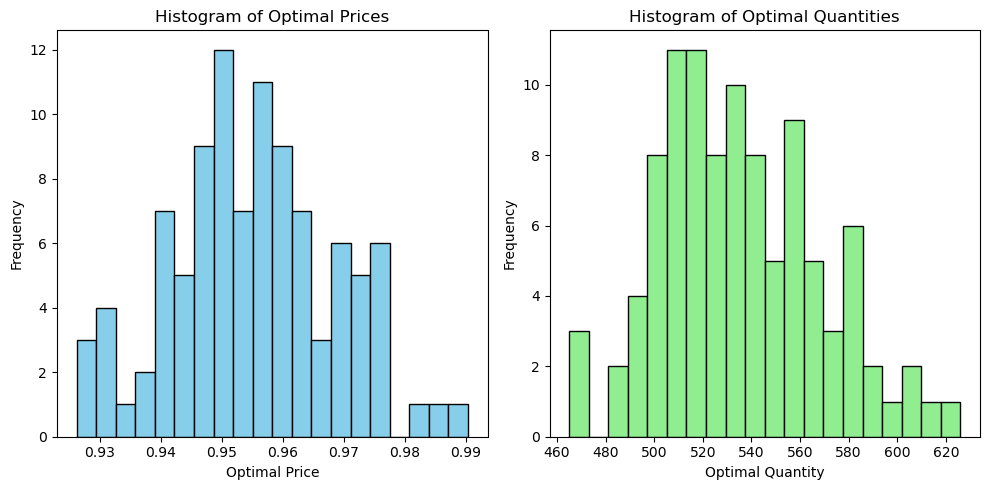

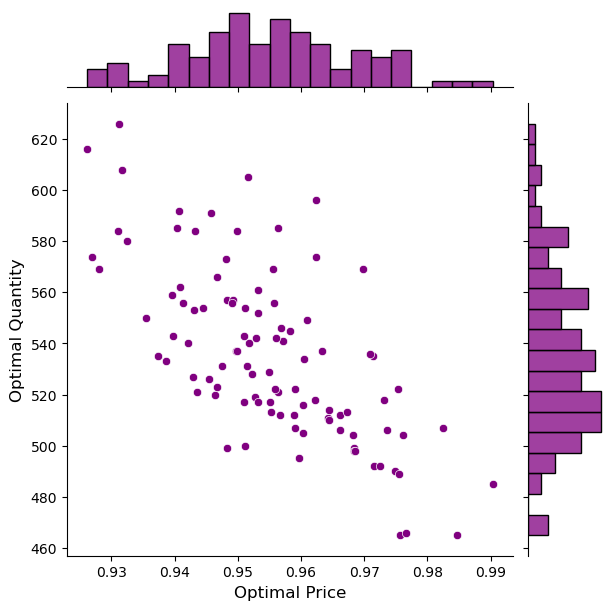

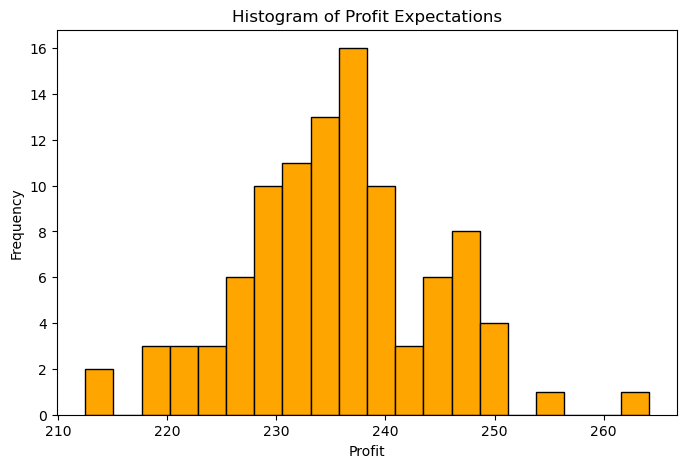

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import gurobipy as gp


# Function for the workflow
def optimize_for_bootstrap(data, random_state=None):
    # Step 1: Bootstrap sampling
    bootstrap_sample = resample(data, replace=True, n_samples=len(data), random_state=random_state)
    X = bootstrap_sample['price'].values.reshape(-1, 1)
    y = bootstrap_sample['demand'].values
    
    # Step 2: Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    beta_0 = model.intercept_
    beta_1 = model.coef_[0]
    residuals = y - model.predict(X)
    
    # Step 3: Define Gurobi model
    c = 0.5
    g = 0.75
    t = 0.15
    
    m2 = gp.Model("newspaper_production_devition2")
    
    # Decision variables
    p_opt = m2.addVar(name="p_optimum", lb=0, vtype=gp.GRB.CONTINUOUS)
    q = m2.addVar(name="q", lb=0, vtype=gp.GRB.INTEGER)
    
    # Generated demand
    generated_demand = beta_0 + (beta_1 * p_opt) + residuals
    n = len(generated_demand)
    
    max_demand_minus_q = m2.addVars(n, name="max_demand_minus_q", lb=0, vtype=gp.GRB.CONTINUOUS)
    max_q_minus_demand = m2.addVars(n, name="max_q_minus_demand", lb=0, vtype=gp.GRB.CONTINUOUS)
    
    # Constraints
    for i in range(n):
        m2.addConstr(max_demand_minus_q[i] >= generated_demand[i] - q)
        m2.addConstr(max_q_minus_demand[i] >= q - generated_demand[i])
    
    # Objective function
    m2.setObjective(
        gp.quicksum(p_opt * generated_demand[i] for i in range(n))/n
        - q * c
        - g * gp.quicksum(max_demand_minus_q[i] for i in range(n))/n
        - t * gp.quicksum(max_q_minus_demand[i] for i in range(n))/n,
        gp.GRB.MAXIMIZE
    )
    
    # Optimize the model
    m2.optimize()
    
    # Extract results
    if m2.status == gp.GRB.OPTIMAL:
        optimal_p = p_opt.x
        optimal_q = q.x
        profit = m2.objVal
        return optimal_p, optimal_q, profit
    else:
        return None, None, None

# Repeat the process for multiple bootstrapped samples
num_iterations = 100  # Number of bootstrapped samples
optimal_prices = []
optimal_quantities = []
profits = []

for i in range(num_iterations):
    result = optimize_for_bootstrap(data, random_state=i)
    if result[0] is not None:
        optimal_prices.append(result[0])
        optimal_quantities.append(result[1])
        profits.append(result[2])

# Create histograms of optimal price and quantity
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(optimal_prices, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Optimal Prices")
plt.xlabel("Optimal Price")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(optimal_quantities, bins=20, color='lightgreen', edgecolor='black')
plt.title("Histogram of Optimal Quantities")
plt.xlabel("Optimal Quantity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Scatterplot with histograms on x and y axes
sns.jointplot(
    x=optimal_prices, 
    y=optimal_quantities, 
    kind="scatter", 
    marginal_kws=dict(bins=20, fill=True),
    color="purple"
).set_axis_labels("Optimal Price", "Optimal Quantity", fontsize=12)
plt.show()

# Histogram of profit expectations
plt.figure(figsize=(8, 5))
plt.hist(profits, bins=20, color='orange', edgecolor='black')
plt.title("Histogram of Profit Expectations")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.show()


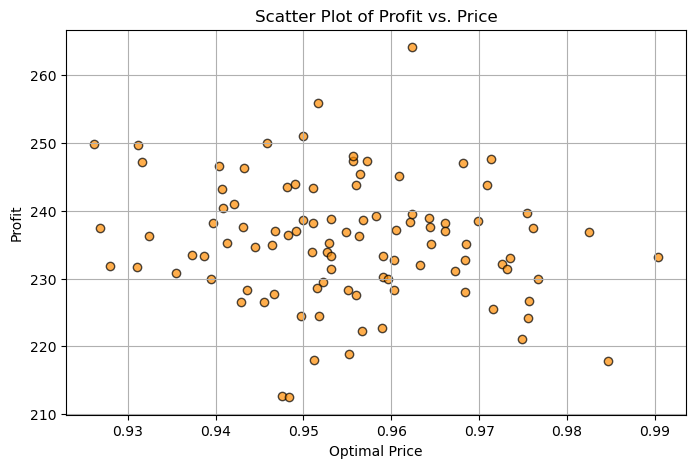

In [12]:
# Scatter plot of Profit vs. Price
plt.figure(figsize=(8, 5))
plt.scatter(optimal_prices, profits, color='darkorange', alpha=0.7, edgecolor='black')
plt.title("Scatter Plot of Profit vs. Price")
plt.xlabel("Optimal Price")
plt.ylabel("Profit")
plt.grid(True)
plt.show()


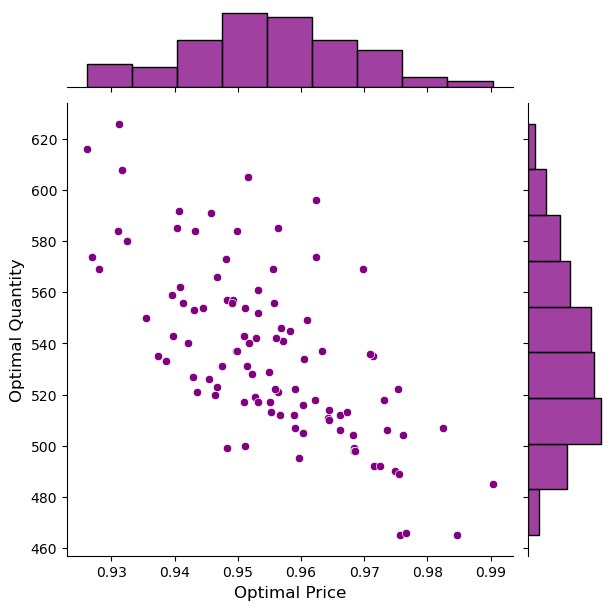

In [13]:
sns.jointplot(
    x=optimal_prices, 
    y=optimal_quantities, 
    kind="scatter", 
    marginal_kws=None,  # Remove histograms on x and y axes
    color="purple"
).set_axis_labels("Optimal Price", "Optimal Quantity", fontsize=12)
plt.show()


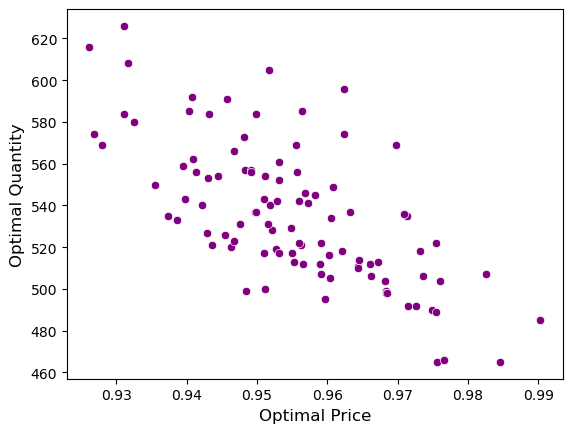

In [14]:
sns.scatterplot(x=optimal_prices, y=optimal_quantities, color="purple")
plt.xlabel("Optimal Price", fontsize=12)
plt.ylabel("Optimal Quantity", fontsize=12)
plt.show()
